### Libraries

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import random 
import numpy as np
import glob
import pandas as pd
from sklearn.metrics import classification_report ,confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load Data

In [ ]:
from google.colab import files
files.upload()
!mkdir -p  ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d uciml/pima-indians-diabetes-database
!unzip pima-indians-diabetes-database.zip


Saving kaggle.json to kaggle (1).json
  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 17.0MB/s]
Archive:  pima-indians-diabetes-database.zip
  inflating: diabetes.csv            


In [ ]:
d = pd.read_csv('diabetes.csv')

## View Data

In [ ]:
d.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
d.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee634b7048>,
      dtype=object)

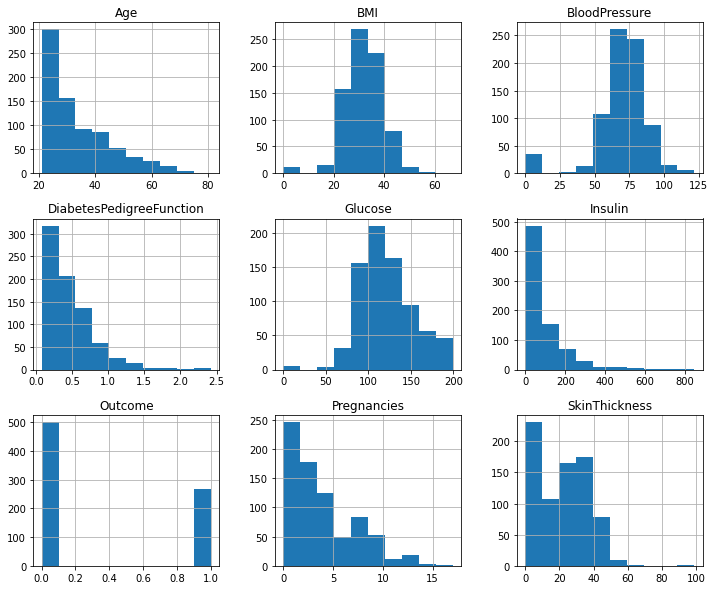

In [ ]:
d.hist(figsize=(12,10))

## Replace 0 value which are actually nan values

In [ ]:
si= SimpleImputer(missing_values=0.0,strategy='constant',fill_value=np.nan)
d.iloc[:,:-1]=si.fit_transform(d.iloc[:,:-1])
d.dropna(inplace=True)

In [ ]:
d.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,3.851190,122.279762,70.244048,28.663690,155.348214,32.297321,0.518702,31.836310,0.330357
std,3.148352,30.784649,12.363401,10.249863,118.777281,6.368558,0.327689,10.458446,0.471043
min,1.000000,56.000000,24.000000,7.000000,15.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.000000,27.800000,0.268000,24.000000,0.000000
50%,3.000000,119.000000,70.000000,28.500000,125.500000,32.750000,0.446500,28.000000,0.000000
75%,6.000000,144.000000,78.000000,36.000000,190.000000,36.250000,0.688250,38.000000,1.000000
max,17.000000,197.000000,110.000000,52.000000,846.000000,57.300000,2.329000,81.000000,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fee62c201d0>,
      dtype=object)

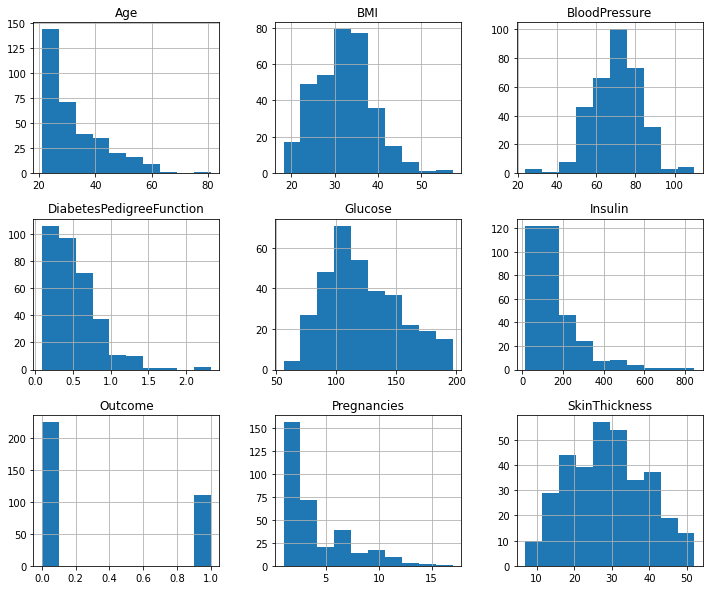

In [ ]:
d.hist(figsize=(12,10))

In [ ]:
d.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,3.851190,122.279762,70.244048,28.663690,155.348214,32.297321,0.518702,31.836310,0.330357
std,3.148352,30.784649,12.363401,10.249863,118.777281,6.368558,0.327689,10.458446,0.471043
min,1.000000,56.000000,24.000000,7.000000,15.000000,18.200000,0.085000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,21.000000,76.000000,27.800000,0.268000,24.000000,0.000000
50%,3.000000,119.000000,70.000000,28.500000,125.500000,32.750000,0.446500,28.000000,0.000000
75%,6.000000,144.000000,78.000000,36.000000,190.000000,36.250000,0.688250,38.000000,1.000000
max,17.000000,197.000000,110.000000,52.000000,846.000000,57.300000,2.329000,81.000000,1.000000


## Divide into data n target

In [ ]:
x,y = d.iloc[:,:-1],d.iloc[:,-1]

In [ ]:
print(x.shape,y.shape)

(336, 8) (336,)


## Preprocess

In [ ]:

ss = StandardScaler()
x = ss.fit_transform(x)
y= np.array(y)

## Divide into Train n Test

In [ ]:
ratio = 0.3
x_train,x_test,y_train,y_test = train_test_split(x, y, test_size =ratio, random_state = 101)

In [ ]:
print("Training Shape ",x_train.shape,y_test.shape)
print("Testing Shape",x_test.shape,y_test.shape)

Training Shape  (235, 8) (101,)
Testing Shape (101, 8) (101,)


## Traiing for different optimzers

In [ ]:
def model_creation(optimizer , loss , activation_h,activation_o):

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(10, input_dim = 8, activation = activation_h))
  model.add(tf.keras.layers.Dense(8, activation = activation_h))
  model.add(tf.keras.layers.Dense(1, activation = activation_o))

  model.compile(optimizer=optimizer,loss=loss,metrics=['accuracy'])

  print(f"Optimizer :{optimizer} ")
  return model
      
def training(model ,x_train,y_train,x_test,y_test,name,epochs=100 ):

  checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f"{name}.h5", monitor = 'val_accuracy',verbose=1,save_best_only=True)
  es=tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=15)
  logs = tf.keras.callbacks.CSVLogger(filename=f"{name}.csv")
  model.fit(x_train, y_train, epochs=epochs, 
                    validation_data=(x_test, y_test),callbacks=[checkpointer,es,logs])
  return model

  


In [ ]:
optimizers = ['adam','sgd','adamax','rmsprop']
loss = 'binary_crossentropy'
activation_h = 'relu'
activation_o = 'relu'

In [ ]:

for o in optimizers:
  m=model_creation(o,loss,activation_h,activation_o)
  model_name = f'pima_dnn_{o}'
  m = training(m,x_train,y_train,x_test,y_test,model_name)

Optimizer :adam 
Epoch 1/100
1/8 [==>...........................] - ETA: 0s - loss: 1.6306 - accuracy: 0.8125
Epoch 00001: val_accuracy improved from -inf to 0.71287, saving model to pima_dnn_adam.h5
8/8 [==============================] - 0s 23ms/step - loss: 4.3732 - accuracy: 0.6511 - val_loss: 3.2844 - val_accuracy: 0.7129
Epoch 2/100
1/8 [==>...........................] - ETA: 0s - loss: 3.0680 - accuracy: 0.7500
Epoch 00002: val_accuracy did not improve from 0.71287
8/8 [==============================] - 0s 4ms/step - loss: 3.8670 - accuracy: 0.6596 - val_loss: 2.9893 - val_accuracy: 0.7129
Epoch 3/100
1/8 [==>...........................] - ETA: 0s - loss: 3.6830 - accuracy: 0.6250
Epoch 00003: val_accuracy improved from 0.71287 to 0.72277, saving model to pima_dnn_adam.h5
8/8 [==============================] - 0s 6ms/step - loss: 3.3995 - accuracy: 0.6638 - val_loss: 2.5713 - val_accuracy: 0.7228
Epoch 4/100
1/8 [==>...........................] - ETA: 0s - loss: 4.3670 - accuracy

## Load all models

In [ ]:
models =  [ tf.keras.models.load_model(x) for x in glob.glob('/content/*.h5')]
logs =  [ pd.read_csv(x) for x in glob.glob('/content/*.csv')]
names = [x.split('/')[-1].split(".")[0] for x in glob.glob('/content/*.csv')]

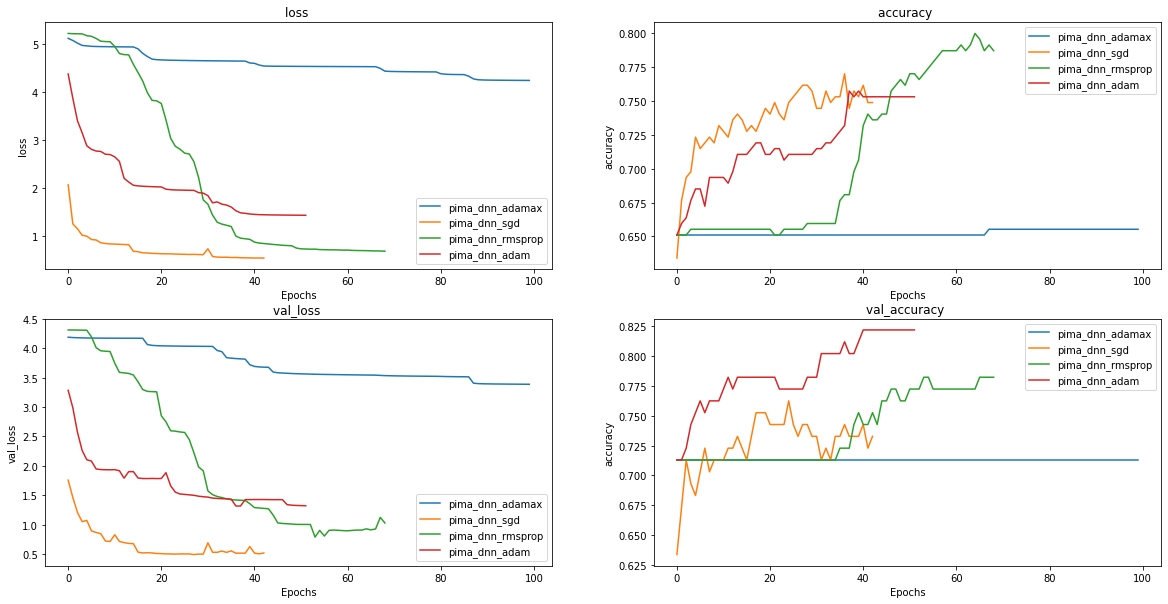

In [ ]:

fig, axs = plt.subplots(2,2,figsize=(20,10))

atr = 'loss'

axs[0,0].plot(logs[0][atr],label=f'{names[0]}')
axs[0,0].plot(logs[1][atr],label=f'{names[1]}')
axs[0,0].plot(logs[2][atr],label=f'{names[2]}')
axs[0,0].plot(logs[3][atr],label=f'{names[3]}')

axs[0,0].set_title(f'{atr} ')
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel(f"{atr}")
axs[0,0].legend(loc="best")

atr2='accuracy'

axs[0,1].plot(logs[0][atr2],label=f'{names[0]}')
axs[0,1].plot(logs[1][atr2],label=f'{names[1]}')
axs[0,1].plot(logs[2][atr2],label=f'{names[2]}')
axs[0,1].plot(logs[3][atr2],label=f'{names[3]}')

axs[0,1].set_title(f'{atr2} ')
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel(f"{atr2}")
axs[0,1].legend(loc="best")

atr3 = 'val_loss'

axs[1,0].plot(logs[0][atr3],label=f'{names[0]}')
axs[1,0].plot(logs[1][atr3],label=f'{names[1]}')
axs[1,0].plot(logs[2][atr3],label=f'{names[2]}')
axs[1,0].plot(logs[3][atr3],label=f'{names[3]}')

axs[1,0].set_title(f'{atr3} ')
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel(f"{atr3}")
axs[1,0].legend(loc="best")

atr4='val_accuracy'

axs[1,1].plot(logs[0][atr4],label=f'{names[0]}')
axs[1,1].plot(logs[1][atr4],label=f'{names[1]}')
axs[1,1].plot(logs[2][atr4],label=f'{names[2]}')
axs[1,1].plot(logs[3][atr4],label=f'{names[3]}')

axs[1,1].set_title(f'{atr4} ')
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel(f"{atr2}")
axs[1,1].legend(loc="best")


In [ ]:
for i in range(4):
  v_loss , v_acc = models[i].evaluate(x_test,  y_test, verbose=0)
  loss , acc = models[i].evaluate(x_train,  y_train, verbose=0)
  print(f"Training loss and accuracy for {names[i]} : {loss} {acc}" )
  print(f"Validation loss and accuracy for {names[i]} : {v_loss} {v_acc} \n\n" )


Training loss and accuracy for pima_dnn_adamax : 0.6161145567893982 0.7531914710998535
Validation loss and accuracy for pima_dnn_adamax : 0.5051943063735962 0.7623762488365173 


Training loss and accuracy for pima_dnn_sgd : 0.7162894606590271 0.778723418712616
Validation loss and accuracy for pima_dnn_sgd : 0.7913349866867065 0.7821782231330872 


Training loss and accuracy for pima_dnn_rmsprop : 5.112092971801758 0.651063859462738
Validation loss and accuracy for pima_dnn_rmsprop : 4.186618328094482 0.7128713130950928 


Training loss and accuracy for pima_dnn_adam : 1.445570945739746 0.7531914710998535
Validation loss and accuracy for pima_dnn_adam : 1.4294276237487793 0.8217821717262268 


